In [426]:
# Projet Advanced programming : Mohammad Moezzibadi - DS2E
%reset -f
import time
from bs4 import BeautifulSoup
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import json
import pickle
import re
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager

from selenium.webdriver import Chrome
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import NoSuchElementException, ElementClickInterceptedException
import requests
from lxml import html

with open('secret.json') as f:
    secrets = json.load(f)

user_id = secrets['username']
passw = secrets['password']
Keyword = 'Data Science'
Location = 'France'

login = "https://www.glassdoor.com/profile/login_input.htm"

def test_page(css_selector, page = ""):
    """Tests whether or not it took to long to access page
        css_selector = css selector that the driver should wait to appear.
        If the css_selector doesn't appear for 20 seconds it exits
    """
    try:
        element = WebDriverWait(driver, 120).until(EC.visibility_of_element_located((By.CSS_SELECTOR,css_selector )))

    except: 
        print("Took Long to access page " + page) 

#############################
def signin_Urls(username = user_id, password = passw, login = login, Keyw = Keyword, loc_ = Location):

    driver.implicitly_wait(10)
    driver.get("https://www.facebook.com") # on fait le sign-in avec le compte Facebook
    time.sleep(3)
    driver.find_element_by_xpath('//*[@title="Tout accepter"]').click()
    try:
        WebDriverWait(driver, 5).until(EC.element_to_be_clickable((By.XPATH,'//*[@title="Tout accepter"]'))).click()
    except KeyError:
        pass
    element=driver.find_element_by_id("email")
    element.send_keys(user_id)
    passwor=driver.find_element_by_id("pass")
    passwor.send_keys(passw)
    time.sleep(3)
    clicker=driver.find_element_by_xpath('//*[@name="login"]')
    clicker.click()
    time.sleep(3)
    
    driver.get(login)
    time.sleep(3)
    submit = driver.find_element_by_xpath('//*[@id="FbButton"]')
    submit.click()
    time.sleep(3)
    submit = driver.find_element_by_xpath('//*[@id="FbButton"]')
    submit.click()
    
    # cookies
    driver.get_cookies()
    pickle.dump( driver.get_cookies() , open("Glass.pkl","wb"))

    cookies = pickle.load(open("Glass.pkl", "rb"))
    for cookie in cookies:
        driver.add_cookie(cookie)
    
    time.sleep(3)
    # Poste
    message_box=driver.find_element_by_css_selector('input#sc\.keyword.css-1etjok6')
    message_box.send_keys(Keyw)
    message_box1=driver.find_element_by_css_selector('input#sc\.location.css-1etjok6')
    time.sleep(3)

    message_box1.clear()
    time.sleep(3)
    # Lieu des entreprises
    message_box1.send_keys(loc_)
    time.sleep(3)
    smallCl= driver.find_element_by_css_selector('div.selectedLabel')
    smallCl.click()
    time.sleep(3)
    # Choix d'entreprise pour les options de recherche
    EntrepriseCl=driver.find_element_by_xpath('//*[@id="option_1"]')
    EntrepriseCl.click()
    Envoi=driver.find_element_by_xpath('//*[@id="scBar"]/div/button')
    Envoi.click()
    #Loop to go over all pages
    UrlSS = []
    URLS = driver.find_elements_by_css_selector("a.eiCell.cell.reviews.d-inline-block.py-sm")
    print(URLS)
    for element in URLS:
        UrlSS.append(element.get_attribute("href"))
    return(UrlSS)
def Page_Entrep(review_page):
    urlToTest = "https://www.glassdoor.fr/Avis/" + review_page + ".htm?filter.iso3Language=fra"
    print(urlToTest)
    driver.get( urlToTest )
    
    test_page("div#EIReviews", review_page)
#############################
def scrape_page( s, before = None, after = None):
    
    def Job(rev):

        jobTitle = rev.find('span', attrs={'class': 'authorJobTitle middle common__EiReviewDetailsStyle__newGrey'})
        if jobTitle != None:
            return jobTitle.get_text().lower()
        else:
            print("Job title was None")
            return None
    
    def scrape_location(rev):

        authorLoc = review.find('span', attrs={'class': 'authorLocation'})
        if authorLoc != None:
            return authorLoc.get_text()
        else:
            print("Author Location was none")
            return None
    
    def scrape_other_ratings(rev):

        sub_ratings = []
        list_of_sub_ratings_to_parse = rev.find_all("span", attrs={'class': 'subRatings__SubRatingsStyles__gdBars gdBars gdRatings med'})
            
        if len(list_of_sub_ratings_to_parse) != 0:
            for sub_rating in list_of_sub_ratings_to_parse:
                sub_ratings.append( float(sub_rating['title']) if sub_rating != None else None )
                # if there aren't 5 ratings
            for i in range(0, 5-len(sub_ratings)):
                sub_ratings.append(None)
            return sub_ratings
        else:
            return [None]*5
        
    def Commentaire(rev):

        Un_Des_Trois = ['Avantages', 'Inconvénients', 'Conseils à la direction']
        PCA = ['pros', 'cons', 'advice-management']
        counter = 0
        pro_con_advice_to_append = []
        TypeOf = []
        regex = re.compile('.*v2__EIReviewDetailsV2__fullWidth.*')
        prosconsadvice = rev.find_all('div', attrs={'class': regex})
        for op in prosconsadvice:
            if op.find('p', attrs={'class': 'mb-0 strong'}) != None:
                op_type = op.find('p', attrs={'class': 'mb-0 strong'}).get_text()
                try:
                    # find actual text of pro, con or advice
                    op_text = op.find('span', attrs={'data-test':PCA[Un_Des_Trois.index(op_type)] })
                    while counter != Un_Des_Trois.index(op_type):
                        pro_con_advice_to_append.append(None)
                        counter +=1
                    if op_text != None:
                        pro_con_advice_to_append.append(op_text.get_text() )
                        TypeOf.append(op_type)
                    else:
                        pro_con_advice_to_append.append( None )
                        
                    counter += 1
                except Exception as e:
                    """ This function relies on each header being in 'Pros', 'Cons', 'Advice to Management'
                    Something changed on glassdoor's site - either the headers or the attributes that reference the headers
                    """
                    print(e)
            else:
                pro_con_advice_to_append.append(None)  
                counter+=1
        while ( counter < 3 ):
            pro_con_advice_to_append.append( None )
            counter+=1
        TypeOf.append('Conseil')    
        return pro_con_advice_to_append,TypeOf

    soup = BeautifulSoup(s, 'lxml')    
    reviews = soup.find_all( 'div', attrs={'class': 'gdReview'})
    if len(reviews) == 0:
        print("No reviews on page!")
        return []   
    output = []    
    for review in reviews:
        rw = []        
        jb= Job(review)
        rw,Tps = Commentaire(review)
        output.append([Tps, rw, [jb]])
    return(output)
#################
# open browser using headless chrome driver
options = webdriver.ChromeOptions() 
#options.headless = True
driver = webdriver.Chrome(ChromeDriverManager().install(), options=options)
############
import os
try:
    os.remove("reviews.json")
except:
    print("Json file created" )
############

URLS = signin_Urls()
reviews = []
company_df = []
for company_page in URLS:
    page_number = 1
    driver.get(company_page)
    # sort the page by date, desc
    try: 
        driver.find_element_by_xpath("//span[@class='subtle']").click()        
    except:
        print("This company probably doesn't have reviews!")
    count = 0
    WebDriverWait(driver, 20)    
    company_page1 =  re.findall(r'\/Avis\/(.*)\.htm', company_page)[0]
    while True: # CHANGE LATER while(True):
        reviewsHTML = driver.page_source
        reviews_page_scraped = scrape_page( reviewsHTML, before = None, after = None )
        with open("reviews.json", "a") as gg:
            json.dump(reviews_page_scraped, gg, ensure_ascii=False)
            gg.write('\n')            
        if len(reviews_page_scraped) == 0:
            break        
        if reviews_page_scraped != "next page":
            company_df = company_df +  reviews_page_scraped      
        page_number += 1
        count +=1
        print(company_page1 + "_P" + str(page_number))
        Page_Entrep(company_page1 + "_P" + str(page_number))

[WDM] - ====== WebDriver manager ======
2021-09-26 17:00:15,889 : INFO : ====== WebDriver manager ======
[WDM] - Current google-chrome version is 93.0.4577
2021-09-26 17:00:16,050 : INFO : Current google-chrome version is 93.0.4577
[WDM] - Get LATEST driver version for 93.0.4577
2021-09-26 17:00:16,052 : INFO : Get LATEST driver version for 93.0.4577


[WDM] - Driver [/Users/moezzibadi/.wdm/drivers/chromedriver/mac64/93.0.4577.63/chromedriver] found in cache
2021-09-26 17:00:16,159 : INFO : Driver [/Users/moezzibadi/.wdm/drivers/chromedriver/mac64/93.0.4577.63/chromedriver] found in cache


[<selenium.webdriver.remote.webelement.WebElement (session="2f6767e46bdf543cb4a3be22bef30e72", element="918e13e0-4edc-484d-9479-c2c69baa33aa")>, <selenium.webdriver.remote.webelement.WebElement (session="2f6767e46bdf543cb4a3be22bef30e72", element="5147dfec-efa8-45ef-baf1-f06ac22ed235")>, <selenium.webdriver.remote.webelement.WebElement (session="2f6767e46bdf543cb4a3be22bef30e72", element="6e6feb28-ce05-4bb2-a0d3-d02f3ea00b61")>, <selenium.webdriver.remote.webelement.WebElement (session="2f6767e46bdf543cb4a3be22bef30e72", element="9d670ae2-95c7-466e-8e3c-2b2adcf1a163")>, <selenium.webdriver.remote.webelement.WebElement (session="2f6767e46bdf543cb4a3be22bef30e72", element="9efb399a-089b-4d08-b415-92a265bb4c14")>, <selenium.webdriver.remote.webelement.WebElement (session="2f6767e46bdf543cb4a3be22bef30e72", element="e8452a80-5bc0-4327-8872-8a91cf644396")>, <selenium.webdriver.remote.webelement.WebElement (session="2f6767e46bdf543cb4a3be22bef30e72", element="f9a56947-c515-4aa0-bb14-42df0c00

In [19]:
%reset -f
# Run in python console
import nltk; nltk.download('stopwords')

import json
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/moezzibadi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/Users/moezzibadi/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_lda.py:28: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps


In [20]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('french')
#stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
print(stop_words)

['au', 'aux', 'avec', 'ce', 'ces', 'dans', 'de', 'des', 'du', 'elle', 'en', 'et', 'eux', 'il', 'ils', 'je', 'la', 'le', 'les', 'leur', 'lui', 'ma', 'mais', 'me', 'même', 'mes', 'moi', 'mon', 'ne', 'nos', 'notre', 'nous', 'on', 'ou', 'par', 'pas', 'pour', 'qu', 'que', 'qui', 'sa', 'se', 'ses', 'son', 'sur', 'ta', 'te', 'tes', 'toi', 'ton', 'tu', 'un', 'une', 'vos', 'votre', 'vous', 'c', 'd', 'j', 'l', 'à', 'm', 'n', 's', 't', 'y', 'été', 'étée', 'étées', 'étés', 'étant', 'étante', 'étants', 'étantes', 'suis', 'es', 'est', 'sommes', 'êtes', 'sont', 'serai', 'seras', 'sera', 'serons', 'serez', 'seront', 'serais', 'serait', 'serions', 'seriez', 'seraient', 'étais', 'était', 'étions', 'étiez', 'étaient', 'fus', 'fut', 'fûmes', 'fûtes', 'furent', 'sois', 'soit', 'soyons', 'soyez', 'soient', 'fusse', 'fusses', 'fût', 'fussions', 'fussiez', 'fussent', 'ayant', 'ayante', 'ayantes', 'ayants', 'eu', 'eue', 'eues', 'eus', 'ai', 'as', 'avons', 'avez', 'ont', 'aurai', 'auras', 'aura', 'aurons', 'aur

In [24]:
import datetime
import calendar
import pandas as pd
import re
# Import Dataset
df = pd.read_json('reviews.json', lines=True)
df1=df.stack().reset_index()
df2 = df1.drop(['level_0', 'level_1'], axis=1)
df3 = df2[0].apply(pd.Series)
df3.head(10).style.set_properties(**{'background-color': 'black',                                                   
                                    'color': 'lawngreen',                       
                                    'border-color': 'white'})
df3['Date'] = [','.join(map(str, l)) for l in df3[2]]
df3['Date'] = df3['Date'].str.split('-', n = 1, expand = True)[0]
df3 = df3.drop([2], axis=1)
df3.columns = ['Type', 'Avis', 'Date']
df3['Type_Avis']= df3.apply(lambda x: list(zip(x.Type,x.Avis)), axis=1)
df3 = df3.explode('Type_Avis')
df3[['Type','Avis']] = pd.DataFrame(df3['Type_Avis'].tolist(), index=df3.index)
df3 = df3.drop(['Type_Avis'], axis=1)
#Enlever les espaces des dates
to_replace=[' ','sept.','août', 'juil.', 'mai', "avr.", "mars", "févr.", "janv.", "déc.", "nov.", "oct.", "juin"]
replace_with=['','sep','aug','jul', 'may' ,"apr", "mar", "feb","jan", "dec", "nov", "oct", "jun"]

df3['Date'] = df3['Date'].replace(to_replace, replace_with, regex=True)
df3 = df3.dropna(axis=0, how="any", thresh=None, subset=None, inplace=False)
df3['Date'] = pd.to_datetime(df3['Date'],format='%d%b%Y')
df3.sort_values(by='Date').reset_index().drop(['index'], axis=1)
# Enlever tous les charactères speciaux
df3['Avis'] = df3['Avis'].apply(lambda x: re.sub('[^A-Za-z0-9éèàê]', ' ', x))
df3

,Type,Avis,Date
0,Avantages,Bon salaire bonne politique de formation de ...,2021-04-06
0,Inconvénients,Après il reste compliqué d évoluer et comme to...,2021-04-06
1,Avantages,Environnement salaire collègues avantages ...,2021-09-20
1,Inconvénients,Loin de mon domicile beaucoup de circulation,2021-09-20
2,Avantages,Business international Bon niveau global des ...,2021-09-13
...,...,...,...
8381,Inconvénients,Très faibles augmentations de salaire Pas d...,2013-09-15
8382,Avantages,Une société prenant des engagements stimulants,2013-03-01
8382,Inconvénients,Environnement de travail très exigeant parfoi...,2013-03-01
8383,Avantages,Cet endroit réunit de personnes intelligentes ...,2010-02-10


In [97]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=False))  # deacc=True removes punctuations
data_words = list(sent_to_words(df3['Avis']))
print(data_words[:2])

[['bon', 'salaire', 'bonne', 'politique', 'de', 'formation', 'de', 'nombreux', 'avantages', 'etc'], ['après', 'il', 'reste', 'compliqué', 'évoluer', 'et', 'comme', 'toute', 'grande', 'entreprise', 'les', 'décisions', 'peuvent', 'prendre', 'du', 'temps']]


In [98]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100) 
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)
print(trigram_mod[bigram_mod[data_words[0]]])

['bon', 'salaire', 'bonne', 'politique', 'de', 'formation', 'de', 'nombreux', 'avantages', 'etc']


In [99]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)
nlp = spacy.load("fr_core_news_sm", disable=['parser', 'ner'])
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
print(data_lemmatized[:3])

[['bon', 'salaire', 'bon', 'politique', 'formation', 'nombreux', 'avantage'], ['reste', 'compliquer', 'évoluer', 'grand', 'entreprise', 'décision', 'pouvoir', 'prendre', 'temps'], ['environnement', 'salair', 'collègue', 'avantage', 'prime']]


In [100]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# Create Corpus
texts = data_lemmatized
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
print(corpus[:1])

[[(0, 1), (1, 2), (2, 1), (3, 1), (4, 1), (5, 1)]]


In [101]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('avantage', 1),
  ('bon', 2),
  ('formation', 1),
  ('nombreux', 1),
  ('politique', 1),
  ('salaire', 1)]]

In [148]:
# Build LDA model
num_of_docs = len(corpus)
corpus_sets = [# gensim.utils.ClippedCorpus(corpus, num_of_docs*0.25), 
               # gensim.utils.ClippedCorpus(corpus, num_of_docs*0.5), 
               gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75))]
#lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
#                                           id2word=id2word,
#                                           num_topics=6, 
#                                           random_state=100,
#                                           update_every=1,
#                                           chunksize=75,
#                                           passes=10,
#                                           alpha='auto',
#                                           per_word_topics=True)
lda_model = gensim.models.LdaMulticore(corpus=gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)),
                                           id2word=id2word,
                                           num_topics=6, 
                                           random_state=100,
                                           chunksize=75,
                                           passes=10,
                                           alpha="asymmetric",
                                           eta=0.91)

In [149]:
# Print the Keyword in the n topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.024*"bon" + 0.023*"travail" + 0.021*"très" + 0.014*"entreprise" + '
  '0.011*"peu" + 0.010*"salair" + 0.010*"ambiance" + 0.010*"beaucoup" + '
  '0.010*"avantage" + 0.010*"salaire"'),
 (1,
  '0.012*"plus" + 0.009*"trop" + 0.008*"faire" + 0.007*"pouvoir" + '
  '0.005*"tout" + 0.005*"an" + 0.004*"manager" + 0.004*"pression" + '
  '0.004*"toujours" + 0.004*"direction"'),
 (2,
  '0.003*"transport" + 0.002*"trouve" + 0.002*"instant" + 0.002*"ecole" + '
  '0.001*"remboursement" + 0.001*"entraid" + 0.001*"téléphone" + '
  '0.001*"stratégique" + 0.001*"inconvénients_particulier" + 0.001*"titre"'),
 (3,
  '0.002*"good" + 0.001*"great" + 0.001*"environment" + 0.001*"traitement" + '
  '0.001*"atmosphèr" + 0.001*"work" + 0.001*"peopl" + 0.001*"benefit" + '
  '0.001*"expérience_enrichisser" + 0.001*"decision"'),
 (4,
  '0.001*"déclarer" + 0.001*"solidité" + 0.001*"négatif" + 0.001*"office" + '
  '0.001*"population" + 0.001*"outils_informatique" + 0.001*"commentaire" + '
  '0.001*"inster" +

In [150]:
# Visualize the topics
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

/Users/moezzibadi/opt/anaconda3/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.262989 -0.031864       1        1  71.507702
1     -0.026400  0.108199       2        1  20.299366
2      0.072105 -0.021636       3        1   2.600409
3      0.073769 -0.019517       4        1   2.201337
4      0.073011 -0.017149       5        1   1.911488
5      0.070505 -0.018032       6        1   1.479698, topic_info=            Term         Freq        Total Category  logprob  loglift
1            bon  2251.000000  2251.000000  Default  30.0000  30.0000
28       travail  2098.000000  2098.000000  Default  29.0000  29.0000
29          très  1950.000000  1950.000000  Default  28.0000  28.0000
95          plus   655.000000   655.000000  Default  27.0000  27.0000
110         trop   786.000000   786.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
421   budgétaire     1.047556    11.423799   Topic6  -7.5051   1.8241
2386    éloigner     0.968452    14.838458   Topic6  -7.5836   1.4841
3385      signer     0.787908     7.281337   Topic6  -7.7899   1.9896
337      réduire     1.028499    33.149517   Topic6  -7.5235   0.7404
1569     gratuit     0.926683    18.813935   Topic6  -7.6277   1.2026

[297 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
8060      1  0.495999   actualité
8060      2  0.247999   actualité
8060      6  0.247999   actualité
3754      1  0.190768     aimable
3754      2  0.190768     aimable
...     ...       ...         ...
264       2  0.024821      équipe
2020      1  0.024753  évaluation
2020      2  0.940602  évaluation
51        1  0.996537   évolution
51        2  0.001371   évolution

[698 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6])

In [151]:
pyLDAvis.save_html(vis, 'lda.html')

In [152]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  #


Perplexity:  -7.537654332082018


In [153]:
# Compute Coherence Score
if __name__ == '__main__':
    __spec__ = "ModuleSpec(name='builtins', loader=<class '_frozen_importlib.BuiltinImporter'>)"
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.6309073875143197


/Users/moezzibadi/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/moezzibadi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/Users/moezzibadi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:164: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doin

In [147]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)),
                                           id2word=dictionary,
                                           num_topics=6, 
                                           random_state=100,
                                           chunksize=75,
                                           passes=10,
                                           alpha="asymmetric",
                                           eta=0.91)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()
compute_coherence_values(gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)), id2word, 6, "assymetric", 0.91)


0.6453748970122724

In [121]:
import numpy as np
import tqdm
grid = {}
grid['Validation_Set'] = {}
# Topics range
min_topics = 2
max_topics = 11
step_size = 1
topics_range = range(min_topics, max_topics, step_size)
# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')
# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')
# Validation sets
num_of_docs = len(corpus)
corpus_sets = [# gensim.utils.ClippedCorpus(corpus, num_of_docs*0.25), 
               # gensim.utils.ClippedCorpus(corpus, num_of_docs*0.5), 
               gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)), 
               corpus]
corpus_title = ['75% Corpus', '100% Corpus']
model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }
# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=540)
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, 
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)                    
                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results.csv', index=False)
    pbar.close()


  0%|▏                                       | 2/540 [02:16<10:12:59, 68.36s/it]

100%|███████████████████████████████████████| 540/540 [6:10:56<00:00, 41.22s/it]


In [122]:
pd.DataFrame(model_results).sort_values(by='Coherence', ascending=False)

,Validation_Set,Topics,Alpha,Beta,Coherence
148,75% Corpus,6,asymmetric,0.91,0.630993
178,75% Corpus,7,asymmetric,0.91,0.628418
418,100% Corpus,6,asymmetric,0.91,0.626573
88,75% Corpus,4,asymmetric,0.91,0.626405
208,75% Corpus,8,asymmetric,0.91,0.624258
...,...,...,...,...,...
2,75% Corpus,2,0.01,0.61,0.407746
4,75% Corpus,2,0.01,symmetric,0.399514
273,100% Corpus,2,0.01,0.91,0.396928
272,100% Corpus,2,0.01,0.61,0.391725


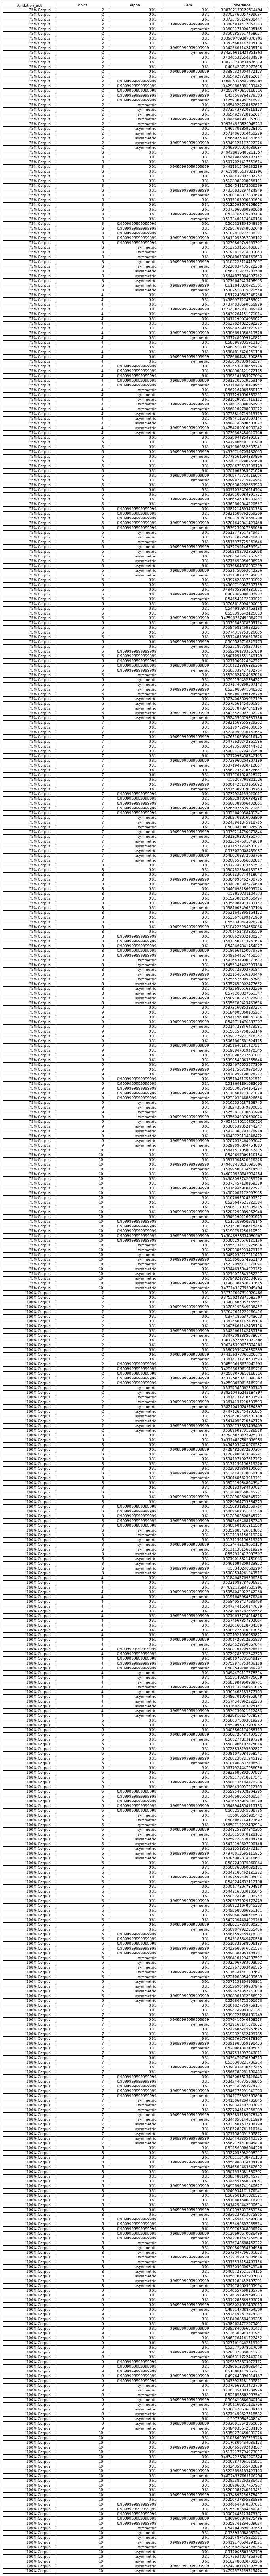

In [503]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
df = pd.DataFrame(model_results)
#https://stackoverflow.com/questions/32137396/how-do-i-plot-only-a-table-in-matplotlib
fig, ax =plt.subplots(figsize=(12,4))
ax.axis('tight')
ax.axis('off')
the_table = ax.table(cellText=df.values,colLabels=df.columns,loc='center')
#https://stackoverflow.com/questions/4042192/reduce-left-and-right-margins-in-matplotlib-plot
pp = PdfPages("foo.pdf")
pp.savefig(fig, bbox_inches='tight')
pp.close()

In [514]:
pd.DataFrame(model_results).to_csv('lda_tuning_results.csv', index=False)


In [575]:
import plotly.figure_factory as ff
import pandas as pd
dataggg = pd.DataFrame(model_results)
fig =  ff.create_table(dataggg.round(decimals = 2).sort_values(by='Coherence', ascending=False).head())
fig.update_layout(
    autosize=False,
    width=600,
    height=200,
)
fig.write_image("table_plotly.png", scale=2)
fig.show()

In [25]:
from nltk.corpus import stopwords
stop_words = (set(stopwords.words('french'))
              | {'le', 'leur', 'afin', 'les', 'leurs', 'après', 'très', 'cela', 'Cet' ' si'}
              | set(stopwords.words('english')))

In [26]:
# Les avis négatives avant 2016
df4 = df3[(df3["Type"] == "Avantages") & (df3["Date"] < "2016-01-01") ]["Avis"]
df4_recent = df3[(df3["Type"] == "Avantages") & (df3["Date"] > "2016-01-01") ]["Avis"]
# Les avis négatives après 2016
df5 = df3[(df3["Type"] == "Inconvénients") & (df3["Date"] < "2016-01-01") ]["Avis"]
df5_recent = df3[(df3["Type"] == "Inconvénients") & (df3["Date"] > "2016-01-01") ]["Avis"]

In [27]:
Avantage = (str(df4))
Inconvénient = (str(df5))
Avantage_recent = (str(df4_recent))
Inconvénient_recent = (str(df5_recent))

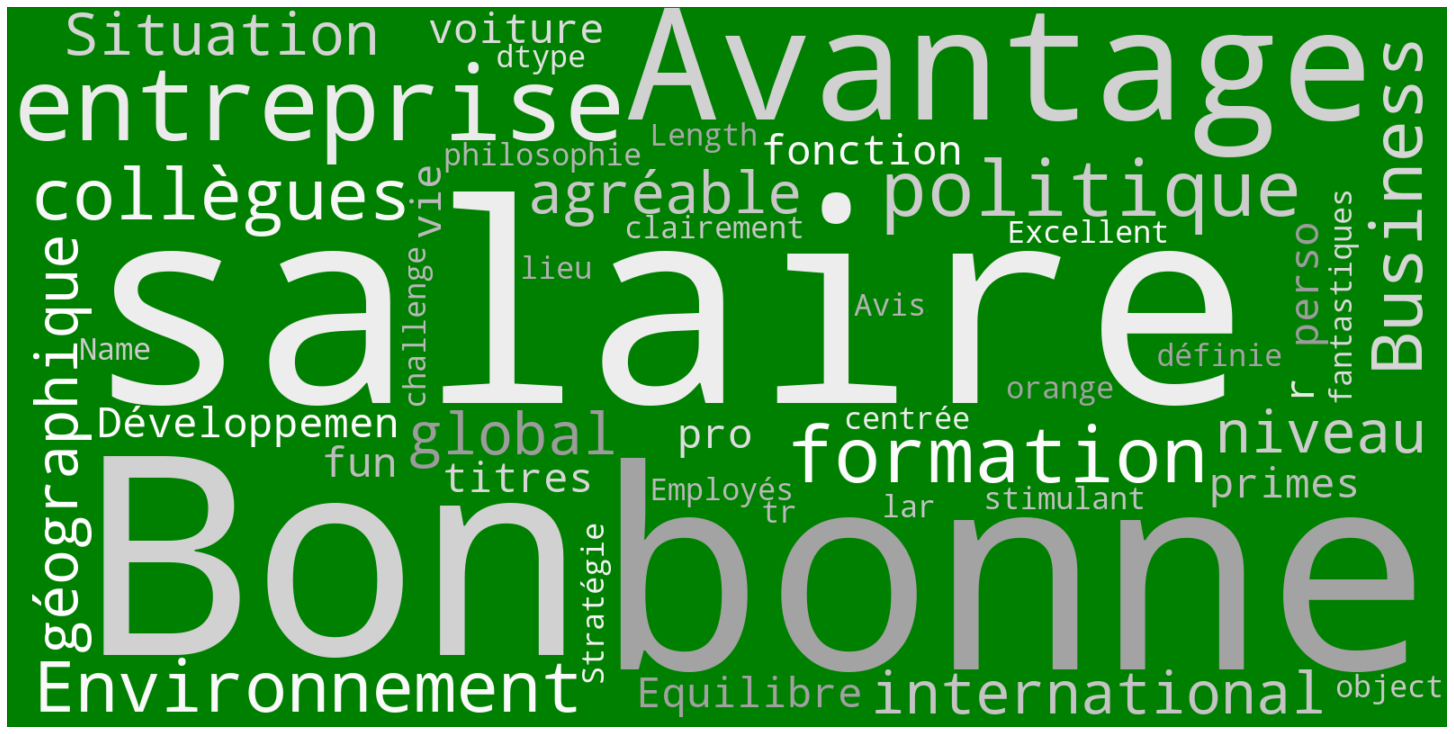

In [30]:
import random

import matplotlib.pyplot as plt
from wordcloud import WordCloud
def grey_color_func(word, font_size,
                    position, orientation,
                    random_state=None,
                    **kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(60, 100)
wordcloud = WordCloud(width=1600, height=800,
                      background_color="green",
                      stopwords=stop_words,
                      random_state=1,
                      color_func=grey_color_func).generate(Avantage_recent)
fig = plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
fig.savefig('wordcloud.png', dpi=fig.dpi)
plt.show()

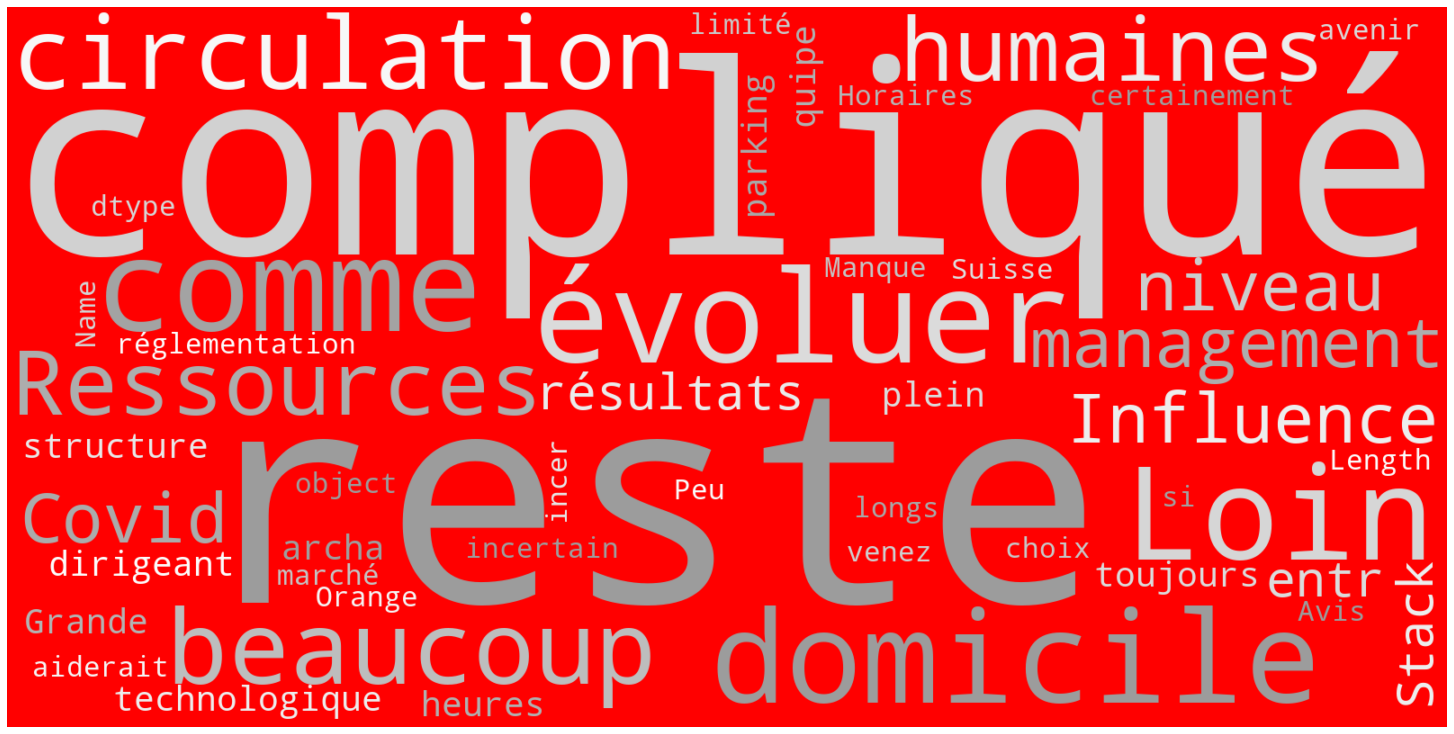

In [31]:
wordcloud = WordCloud(width=1600, height=800,
                      background_color="red",
                      stopwords=stop_words,
                      random_state=1,
                      color_func=grey_color_func).generate(Inconvénient_recent)
fig = plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
fig.savefig('wordcloud1.png', dpi=fig.dpi)
plt.show()

In [195]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

df3.loc[df3['Type']== 'Avantages', 'Type'] = 1
df3.loc[df3['Type']== 'Inconvénients', 'Type'] = 0
Rev_type = []
Rev_type = df3['Type'].tolist()
Rev_text = []
Rev_text = df3['Avis'].tolist()
from collections import Counter 
c = Counter(Rev_type)
print(c)
import nltk 
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
from nltk import pos_tag
from nltk.stem import PorterStemmer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

def preprocessing(text):
    text2 = " ".join("".join([" " if ch in string.punctuation else ch for ch in text]).split()) # on remplace  le pontion 
    tokens = [word for sent in nltk.sent_tokenize(text2) for word in 
            nltk.word_tokenize(sent)]
    tokens = [word.lower() for word in tokens]
    stopwds = stopwords.words('english') + stopwords.words('french') # le mot anglais pour dectecter
    tokens = [token for token in tokens if token not in stopwds]
    tokens = [word for word in tokens if len(word)>=3]# on supprime tous les mots <3 
    stemmer = PorterStemmer() # permet récupperer le radical du mot 
    tokens = [stemmer.stem(word) for word in tokens]# que le mot suit un nom, verbe il recupère que la racine du mot
    tagged_corpus = pos_tag(tokens) #permet de traiter les séquences des mots 
    
    Noun_tags = ['NN','NNP','NNPS','NNS'] 
    Verb_tags = ['VB','VBD','VBG','VBN','VBP','VBZ'] 
    lemmatizer = WordNetLemmatizer()
    def prat_lemmatize(token,tag): 
        if tag in Noun_tags: 
            return lemmatizer.lemmatize(token,'n') 
        elif tag in Verb_tags: 
            return lemmatizer.lemmatize(token,'v') 
        else: 
            return lemmatizer.lemmatize(token,'n')        
    pre_proc_text =  " ".join([prat_lemmatize(token,tag) for token,tag in tagged_corpus])              
    return pre_proc_text
smsdata_data_2 = [] 
for i in Rev_text: 
    smsdata_data_2.append(preprocessing(i))     
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(smsdata_data_2, Rev_type, random_state=1)

from sklearn.feature_extraction.text import TfidfVectorizer #permet de vectorizer les lignes des données
final_stopwords_list = stopwords.words('english') + stopwords.words('french')
vectorizer = TfidfVectorizer(min_df=2, ngram_range=(1, 2),  stop_words=final_stopwords_list,  
    max_features= 4000,strip_accents='unicode',  norm='l2')# limite le 4000 mots le plus fréquent pour faire notre prédiction 

x_train_2 = vectorizer.fit_transform(X_train).todense() # todense : permet des créer les données afin d e visualiser les contenus 
x_test_2 = vectorizer.transform(X_test).todense()

from sklearn.naive_bayes import MultinomialNB # classificateur multinomial( estimateur de Laplace)
clf = MultinomialNB().fit(x_train_2, y_train) 

ytest_nb_predicted = clf.predict(x_test_2) 
ytrain_nb_predicted = clf.predict(x_train_2) 
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train, ytrain_nb_predicted)
cm

Counter({1: 8384, 0: 8384})


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/moezzibadi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/moezzibadi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/moezzibadi/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/moezzibadi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/Users/moezzibadi/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['etaient', 'etais', 'etait', 'etant', 'etante', 'etantes', 'etants', 'ete', 'etee', 'etees', 'etes', 'etiez', 'etions', 'eumes', 'eutes', 'fumes', 'futes

array([[5759,  490],
       [ 419, 5908]])

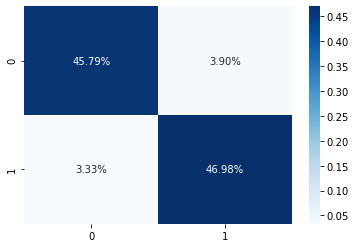

In [201]:
sns.heatmap(cm/np.sum(cm), annot=True, 
            fmt='.2%', cmap='Blues')
plt.savefig('CM.png')